In [23]:
# Формируем строку для описания архитектуры модели
def get_model_architecture(model):
    architecture = ""
    for layer in model.layers:
        if isinstance(layer, LSTM):
            architecture += f"LSTM_{layer.units}x{layer.return_sequences}_"
        elif isinstance(layer, Dense):
            architecture += f"Dense{layer.units}_"
    return architecture[:-1]  # Убираем последний символ "_"

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
import joblib
from numpy import sqrt
from keras.losses import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from keras.models import load_model

from free_utils import (
    file_names,
    n_intervals
)

In [31]:

# Путь для сохранения моделей
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


n_intervals = 120
file_id = 4


n_features = 18
data_folder = '../datasets/'
# Загрузка скейлеров
scaler_filename = '../scalers/' + file_names[file_id] + '_scaler.pkl'
with open(scaler_filename, 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)
# Создаем списки для хранения путей и данных
file_paths = [
    'X_test_ltsm_',
    'X_train_ltsm_',
    'y_test_ltsm_',
    'y_train_ltsm_'
]

data = []

# Загружаем данные из файлов .npy
for file_path in file_paths:
    file_name = file_path + file_names[file_id] + '.npy'
    full_path = data_folder + file_name
    data.append(np.load(full_path))

# Теперь переменная 'data' содержит загруженные данные из файлов .npy
X_test_ltsm, X_train_ltsm, y_test_ltsm, y_train_ltsm = data

In [26]:

model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_ltsm.shape[1], X_train_ltsm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=False,))
model.add(Dropout(0.2))
model.add(Dense(units=100,activation = 'relu'))
model.add(Dense(units=1,activation = 'linear'))


model.compile(optimizer='adam',loss='mse')


model_architecture = get_model_architecture(model)
print("Model architecture:", model_architecture)

# Определение колбеков
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Формируем путь для сохранения модели
model_filename = os.path.join(models_dir, f'{file_names[file_id]}_{model_architecture}_best_model.h5')
model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', save_best_only=True)


Model architecture: LSTM_100xTrue_LSTM_100xFalse_Dense100_Dense1


In [27]:
# Обучение модели с использованием колбеков
history = model.fit(
                    X_train_ltsm, y_train_ltsm,
                    epochs=30, batch_size=32,
                    validation_data=(X_test_ltsm, y_test_ltsm),
                    callbacks=[early_stopping, model_checkpoint],
                    )

Epoch 1/30
64/64 [==============================] - 6s 43ms/step - loss: 0.0087 - val_loss: 0.0108
Epoch 2/30
64/64 [==============================] - 2s 30ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 3/30
64/64 [==============================] - 2s 31ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 4/30
64/64 [==============================] - 2s 31ms/step - loss: 9.0420e-04 - val_loss: 0.0010
Epoch 5/30
64/64 [==============================] - 2s 29ms/step - loss: 8.5428e-04 - val_loss: 0.0014
Epoch 6/30
64/64 [==============================] - 2s 29ms/step - loss: 8.7326e-04 - val_loss: 0.0011
Epoch 7/30
64/64 [==============================] - 2s 29ms/step - loss: 7.9753e-04 - val_loss: 0.0024
Epoch 8/30
64/64 [==============================] - 2s 29ms/step - loss: 7.1174e-04 - val_loss: 0.0011
Epoch 9/30
64/64 [==============================] - 2s 30ms/step - loss: 5.7083e-04 - val_loss: 0.0011


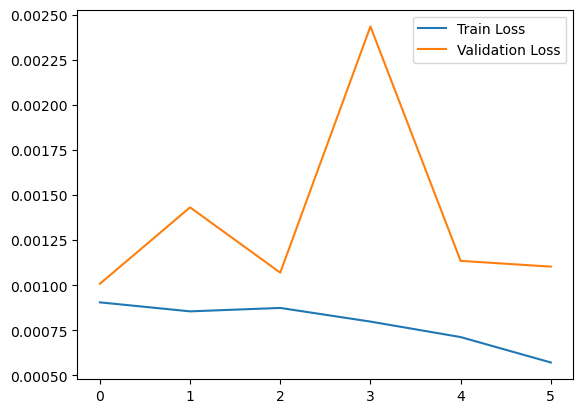

In [28]:
# Визуализация процесса обучения, начиная с 4-й эпохи
plt.plot(history.history['loss'][3:], label='Train Loss')
plt.plot(history.history['val_loss'][3:], label='Validation Loss')
plt.legend()
plt.show()

In [29]:
# # Путь к сохраненной модели
# saved_model_path = 'models/Прошлые данные - LKOH.csv_LSTM_100xTrue_LSTM_100xFalse_Dense256_Dense256_Dense1_best_model.h5'
#     
# # Загружаем модель
# loaded_model = load_model(saved_model_path)
# model = loaded_model
# Теперь у вас есть загруженная модель, готовая к использованию


In [32]:
X_train_ltsm_res = X_train_ltsm.reshape((X_train_ltsm.shape[0], n_intervals*n_features))

# invert scaling for actual
y_train_ltsm_res = y_train_ltsm.reshape((len(y_train_ltsm), 1))
inv_y_train = np.concatenate((y_train_ltsm_res, X_train_ltsm_res[:, (1-n_features):]), axis=1)

inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [33]:
yhat = model.predict(X_test_ltsm)
X_test_ltsm_res = X_test_ltsm.reshape((X_test_ltsm.shape[0], n_intervals*n_features))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test_ltsm_res[:, (1-n_features):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y_test_ltsm = y_test_ltsm.reshape((len(y_test_ltsm), 1))
inv_y_test = np.concatenate((y_test_ltsm, X_test_ltsm_res[:, (1-n_features):]), axis=1)

inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
    

16/16 [==============================] - 1s 13ms/step


Test RMSE: 23.732


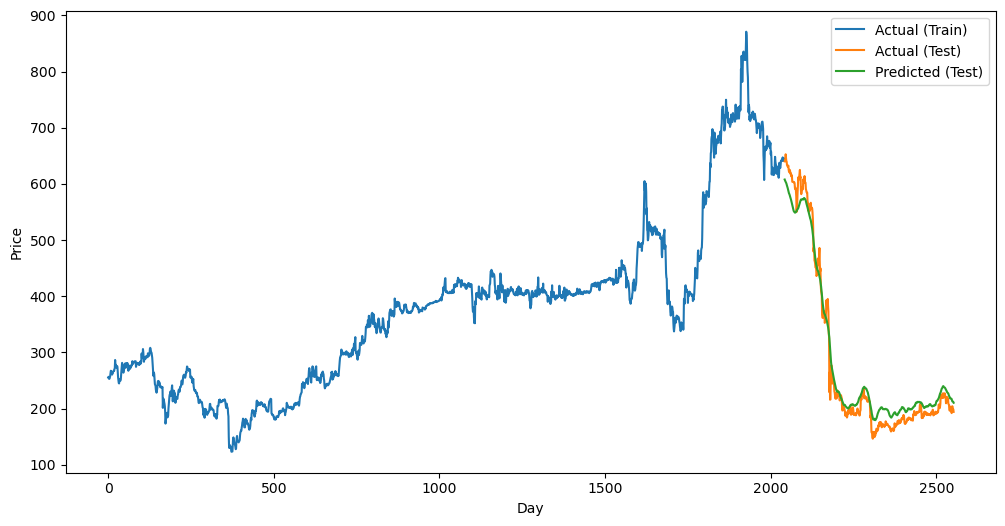

In [34]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat))

# Print RMSE
print("Test RMSE: %.3f" % rmse)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(inv_y_train, label='Actual (Train)')
plt.plot(range(len(inv_y_train), len(inv_y_train) + len(inv_y_test)), inv_y_test, label='Actual (Test)')
plt.plot(range(len(inv_y_train), len(inv_y_train) + len(inv_y_test)), inv_yhat, label='Predicted (Test)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


In [35]:
# Прогнозирование следующих 300 дней
forecast_days = n_intervals
forecast = []

# Используем последние 60 дней из тестового набора
last_60_days = X_test_ltsm[-n_intervals:]

for i in range(forecast_days):
    # Используйте модель для прогнозирования следующего дня
    next_day_prediction = model.predict(last_60_days)

    # Добавьте прогноз в список прогнозов
    forecast.append(next_day_prediction[0, 0])

    # Обновите last_60_days, удалив первый день и добавив новый прогноз
    last_60_days = np.roll(last_60_days, shift=-1, axis=0)
    last_60_days[-1] = next_day_prediction

# Обратное масштабирование прогнозов
forecast = np.array(forecast)
# Повторяем прогнозы для каждого признака
forecast = np.repeat(forecast, n_features).reshape(-1, n_features)
forecast = scaler.inverse_transform(forecast)[:, 0]

# Результаты прогнозирования
print("Прогнозы на следующие 300 дней:")
print(forecast)

4/4 [==============================] - 0s 10ms/step
Прогнозы на следующие 300 дней:
[204.49702 205.20348 204.86093 206.69424 208.83395 210.45107 210.74683
 210.1207  210.46375 211.14291 211.97586 212.1431  211.48412 211.67198
 211.9984  212.16534 211.87689 210.71716 210.6456  210.83902 211.09589
 210.94972 209.64696 209.15231 208.09953 206.83595 205.19202 203.97287
 203.2641  202.26186 201.0717  201.29044 202.05269 203.02536 203.5481
 203.07349 203.6227  204.35272 204.59517 204.46983 203.77728 203.85397
 204.17209 204.6268  206.08032 206.79848 207.42168 207.89503 208.08913
 207.66545 206.37448 205.58492 205.14935 204.74355 203.9811  203.87158
 204.39594 205.23653 205.47719 204.75446 204.98254 205.57445 206.09944
 206.35117 206.19688 208.49545 210.94017 213.06145 213.83188 213.7487
 214.30737 215.4323  216.81358 218.03258 218.79027 220.41148 222.64667
 225.0176  226.77426 227.80342 229.35065 231.45796 233.53807 235.42326
 236.3122  237.08095 238.74573 239.8051  240.12196 238.9422  238.2

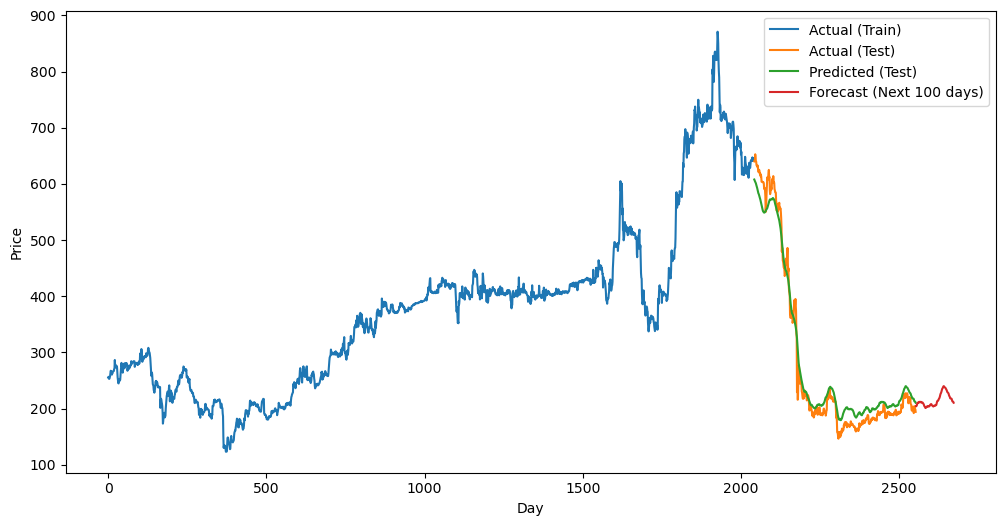

In [36]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(inv_y_train, label='Actual (Train)')
plt.plot(range(len(inv_y_train), len(inv_y_train) + len(inv_y_test)), inv_y_test, label='Actual (Test)')
plt.plot(range(len(inv_y_train), len(inv_y_train) + len(inv_y_test)), inv_yhat, label='Predicted (Test)')
plt.plot(range(len(inv_y_train) + len(inv_y_test), len(inv_y_train) + len(inv_y_test) + len(forecast)), forecast, label='Forecast (Next 100 days)')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
# # Изменим форму массива на ожидаемую
# # Изменим форму массива на ожидаемую
# predictions_inverted = predictions_inverted.reshape(-1, num_days)
# 
# predictions_inverted = predictions_inverted.transpose()
# predictions_LTSM_test = predictions_inverted
# 
# # Inverse transform the predictions
# y_test_LTSM = scaler.inverse_transform(y_test_LTSM.reshape(-1, 1))
# # Calculate metrics
# mse = mean_squared_error(y_test_LTSM, predictions_LTSM_test)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test_LTSM, predictions_LTSM_test)
# 
# print('RMSE (Root Mean Squared Error):', rmse)
# print('R2 (Coefficient of Determination):', r2)
# def calculate_mape(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# 
# # Вычисляем MAPE
# mape = calculate_mape(y_test_LTSM, predictions_LTSM_test)
# print('MAPE (Mean Absolute Percentage Error):', mape)
